In [260]:
# Import necessary libraries
from sklearn.pipeline import Pipeline
import numpy as np
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.model_selection import train_test_split
from tools.SLModelTrainer import SLModelTrainer
from tools.SLModelEvaluator import SLModelEvaluator
from transformers.DropHighNaNColumnsTransformer import DropHighNaNColumnsTransformer
from tools.EDA import EDA
from tools.DataLoader import DataLoader

# Import necessary libraries
from sklearn.impute import SimpleImputer
from category_encoders import TargetEncoder
from sklearn.preprocessing import PowerTransformer
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn import set_config
import pandas as pd
from sklearn.discriminant_analysis import StandardScaler

# Import Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [261]:
# Step 1: Load Data using DataLoader
data_loader = DataLoader(request_type="local", path="db/final_proj_data.csv")
df = data_loader.load_data()

In [262]:
data_loader_valid = DataLoader(request_type="local", path="db/final_proj_test.csv")
df_valid = data_loader_valid.load_data()

In [263]:
# Step 2: Perform EDA using the EDA class
eda = EDA(df)
eda.perform_full_eda()

Dataset Information:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 231 entries, Var1 to y
dtypes: float64(191), int64(2), object(38)
memory usage: 17.6+ MB


None

,Column,Has_Nulls,Dtype
Var1,Var1,True,float64
Var2,Var2,True,float64
Var3,Var3,True,float64
Var4,Var4,True,float64
Var5,Var5,True,float64
...,...,...,...
Var227,Var227,False,object
Var228,Var228,False,object
Var229,Var229,True,object
Var230,Var230,True,float64



Dataset Shape:

(10000, 231)

Descriptive Statistics:



,count,mean,std,min,25%,50%,75%,max
Var1,133.0,14.977444,66.456008,0.0,0.000,0.00,16.000,680.0
Var2,266.0,0.000000,0.000000,0.0,0.000,0.00,0.000,0.0
Var3,266.0,341.052632,2810.606975,0.0,0.000,0.00,0.000,42588.0
Var4,280.0,0.096429,0.928243,0.0,0.000,0.00,0.000,9.0
Var5,241.0,233810.124481,553230.515446,0.0,0.000,0.00,117235.000,3024000.0
...,...,...,...,...,...,...,...,...
Var189,4206.0,272.455064,86.752531,6.0,204.000,270.00,330.000,642.0
Var190,43.0,25725.112326,37487.484852,0.0,1312.875,10853.82,37491.525,191167.2
Var209,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Var230,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN



Missing Values:



Var1       9867
Var2       9734
Var3       9734
Var4       9720
Var5       9759
          ...  
Var227        0
Var228        0
Var229     5561
Var230    10000
y             0
Length: 231, dtype: int64


Sample Data:



,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,...,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230,y
0,NaN,NaN,NaN,NaN,NaN,812.0,14.0,NaN,NaN,NaN,...,catzS2D,jySVZNlOJy,NaN,xG3x,Aoh3,ZI9m,ib5G6X1eUxUn6,mj86,NaN,0
1,NaN,NaN,NaN,NaN,NaN,2688.0,7.0,NaN,NaN,NaN,...,i06ocsg,LM8l689qOp,NaN,kG3k,WqMG,RAYp,55YFVY9,mj86,NaN,0
2,NaN,NaN,NaN,NaN,NaN,1015.0,14.0,NaN,NaN,NaN,...,P6pu4Vl,LM8l689qOp,NaN,kG3k,Aoh3,ZI9m,R4y5gQQWY8OodqDV,am7c,NaN,0
3,NaN,NaN,NaN,NaN,NaN,168.0,0.0,NaN,NaN,NaN,...,BNrD3Yd,LM8l689qOp,NaN,NaN,FSa2,RAYp,F2FyR07IdsN7I,NaN,NaN,0
4,NaN,NaN,NaN,NaN,NaN,14.0,0.0,NaN,NaN,NaN,...,3B1QowC,LM8l689qOp,NaN,NaN,WqMG,RAYp,F2FyR07IdsN7I,NaN,NaN,0


In [264]:
# Define categorical transformer for RandomForest
cat_transformer_rf = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", TargetEncoder(handle_unknown="ignore")),
    ]
).set_output(transform="pandas")

# Define numerical transformer for RandomForest
num_transformer_rf = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="mean")),
    ]
).set_output(transform="pandas")

# Define preprocessor for RandomForest
preprocessor_rf = ColumnTransformer(
    transformers=[
        ("num", num_transformer_rf, make_column_selector(dtype_include=np.number)),
        (
            "cat",
            cat_transformer_rf,
            make_column_selector(dtype_include=[object, "category"]),
        ),
    ],
    n_jobs=-1,
    verbose_feature_names_out=False,
).set_output(transform="pandas")

In [265]:
# Full preprocessing pipeline for RandomForest without nested Pipelines
full_pipeline_random_forest = ImbPipeline(
    steps=[
        ("drop_high_nan", DropHighNaNColumnsTransformer(threshold=0.8)),
        ("preprocessing", preprocessor_rf),
        # ("smote", SMOTE(random_state=42)),
        # ("pca", PCA(n_components=0.95)),
        ("model", RandomForestClassifier(random_state=42)),
    ]
)

In [266]:
# Define categorical transformer for GradientBoosting
cat_transformer_gb = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", TargetEncoder(handle_unknown="ignore")),
    ]
).set_output(transform="pandas")

# Define numerical transformer for GradientBoosting
num_transformer_gb = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="mean")),
        # ("scaler", StandardScaler()),
        # ("power", PowerTransformer()),
    ]
).set_output(transform="pandas")

# Define preprocessor for GradientBoosting
preprocessor_gb = ColumnTransformer(
    transformers=[
        ("num", num_transformer_gb, make_column_selector(dtype_include=np.number)),
        (
            "cat",
            cat_transformer_gb,
            make_column_selector(dtype_include=[object, "category"]),
        ),
    ],
    n_jobs=-1,
    verbose_feature_names_out=False,
).set_output(transform="pandas")

In [267]:
# Full preprocessing pipeline for GradientBoosting without nested Pipelines

full_pipeline_gradient_boosting = ImbPipeline(
    steps=[
        ("drop_high_nan", DropHighNaNColumnsTransformer(threshold=0.8)),
        ("preprocessing", preprocessor_gb),
        # ("power", PowerTransformer()),
        # ("smote", SMOTE(random_state=42)),
        # ("pca", PCA(n_components=0.95)),
        ("model", GradientBoostingClassifier(random_state=42)),
    ]
)

In [268]:
X = df.drop(columns=["y"])
y = df["y"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [269]:
# # Define the parameter grid for RandomForest
# param_grids = {
#     "random_forest": {
#         "model__n_estimators": [100, 200, 300],
#         "model__max_depth": [10, 20, 30],
#         "model__min_samples_split": [2, 5, 10],
#         "model__min_samples_leaf": [1, 2, 4],
#         "model__bootstrap": [True, False],
#     },
#     "gradient_boosting": {
#         "model__n_estimators": [100, 200, 300],
#         "model__learning_rate": [0.01, 0.05, 0.1, 0.2],
#         "model__max_depth": [3, 5, 7],
#         "model__min_samples_split": [2, 5, 10],
#         "model__min_samples_leaf": [1, 2, 4],
#         "model__subsample": [0.8, 1.0],
#     },
# }

# Define the parameter grid for RandomForest
param_grids = {
    "random_forest": {
        "model__n_estimators": [100],
        "model__max_depth": [10],
        "model__min_samples_split": [2],
        "model__min_samples_leaf": [1],
        "model__bootstrap": [True],
    },
    "gradient_boosting": {
        "model__n_estimators": [100],
        "model__learning_rate": [0.01],
        "model__max_depth": [3],
        "model__min_samples_split": [2],
        "model__min_samples_leaf": [1],
        "model__subsample": [0.8],
    },
}

In [270]:
# Combine pipelines into a dictionary
model_pipelines = {
    # "random_forest": full_pipeline_random_forest,
    "gradient_boosting": full_pipeline_gradient_boosting,
}

In [271]:
model_trainer = SLModelTrainer()
model_trainer.train(
    X_train, y_train, model_pipelines, param_grids, scoring="accuracy", cv=5
)

/home/nord/.local/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/nord/.local/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/nord/.local/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/nord/.local/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 345, in _score
    y_pred = method_caller(
             ^^^^^^^^^^^^^^
  File "/home/nord/.local/lib/python3.12/site-packages/sklearn/metrics/_score

In [272]:
best_models = model_trainer.best_estimators
best_params = model_trainer.best_params
best_scores = model_trainer.best_scores
best_model = model_trainer.best_model_name

In [273]:
# Инициализация и использование класса SLModelEvaluator
evaluator = SLModelEvaluator()

In [275]:
evaluator.visualize_pipeline(model_name=best_model, best_models=best_models)

KeyError: None

In [274]:
evaluator.display_results(X_valid=X_test, y_valid=y_test, best_models=best_models, best_params=best_params, best_scores=best_scores, best_model_name=best_model, help_text=True)

ValueError: Input X contains NaN.
GradientBoostingClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

In [ ]:
evaluator.validate_on_test(X_test, y_test, best_models[best_model], best_model_name=best_model)

Results for random_forest:


,Accuracy,F1 Score,Precision,Recall
random_forest,0.8855,0.859702,0.867898,0.8855


In [ ]:
X_train_F = DropHighNaNColumnsTransformer(threshold=0.8).fit_transform(X_train)
X_train_T = preprocessor_rf.fit_transform(X_train_F, y_train)

In [ ]:
edaT = EDA(X_train_T)
edaT.missing_values()


Missing Values:



Var6      0
Var7      0
Var13     0
Var21     0
Var22     0
         ..
Var225    0
Var226    0
Var227    0
Var228    0
Var229    0
Length: 76, dtype: int64

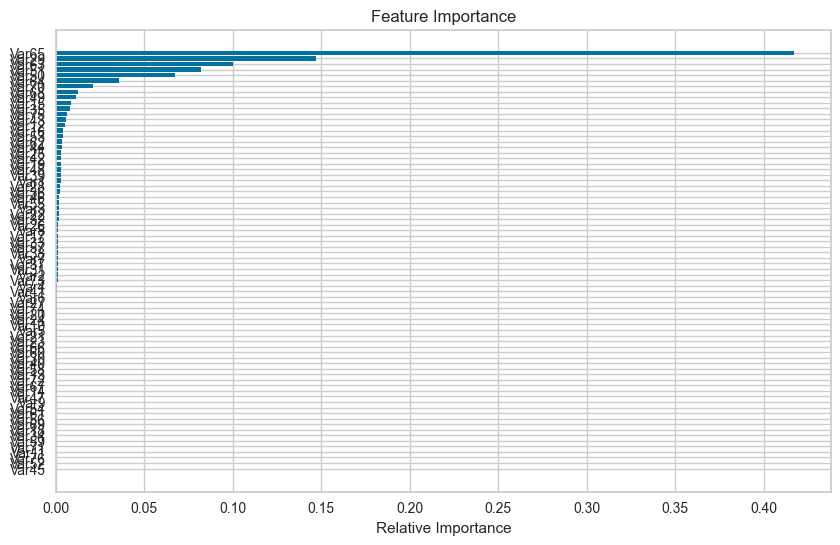

In [ ]:
evaluator.feature_importance(X_train_T, y_train, df)

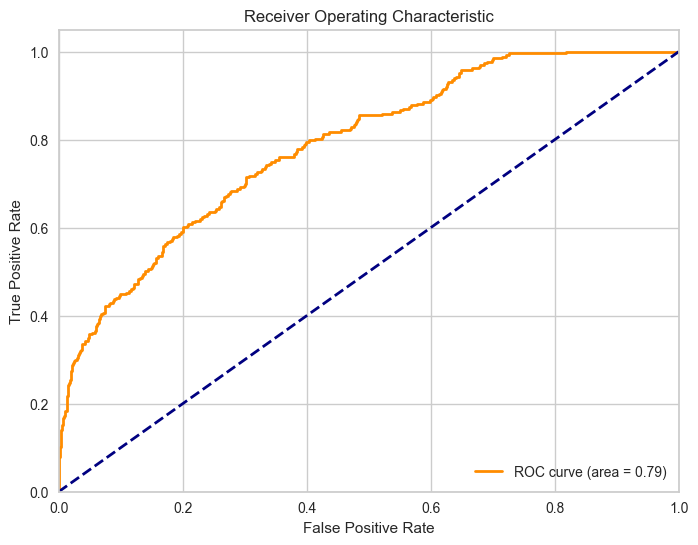

In [ ]:
evaluator.plot_roc_curve(
    model=best_models[best_model], X_test=X_test, y_test=y_test
)

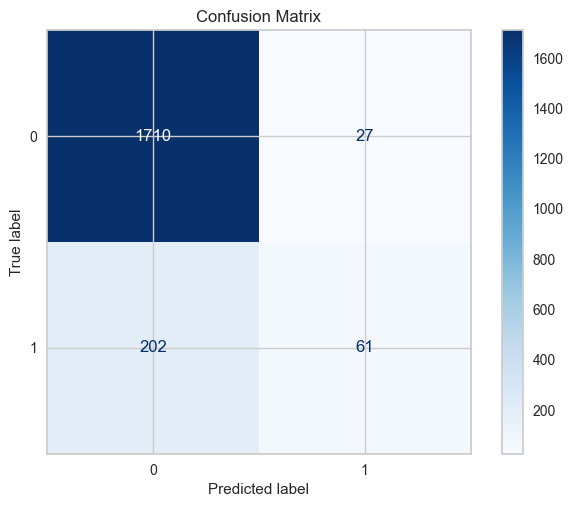

In [ ]:
evaluator.plot_confusion_matrix(
    model=best_models[best_model], X_test=X_test, y_test=y_test
)

In [ ]:
predictions = best_models[best_model].predict(df_valid)

output = pd.DataFrame({"index": df_valid.index, "y": predictions})

output.head()

,index,y
0,0,0
1,1,1
2,2,0
3,3,0
4,4,0
